- Nate Diaz
- Predictive Analytics

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

# Predicting 30-Day Hospital Readmissions for Diabetic Patients

## EDA & Data Cleaning

For this project, I am using the “Diabetes 130-US Hospitals for Years 1999-2008” dataset from the UC Irvine Machine Learning Repository. The dataset includes 101,766 patient encounters from 130 US hospitals over 10 years, with 50 features covering patient demographics, lab results, medications, and admission/discharge information.

My primary goal is to predict whether a patient with diabetes will be readmitted within 30 days of discharge. This is a classification problem, and my initial modeling plan involves logistic regression and potentially random forests due to the high dimensionality of the dataset. Emphasis will be placed on recall, since false negatives could lead to patients not receiving necessary care.

### Data

In [8]:
data = pd.read_csv('diabetic_data.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [10]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Data Mapping Info

A lot of the data is already encoded, along with the dataset, was included the following mapping data for the encoded columns. This also helps actually know what the values mean for these columns as without it they'd just be random numbers.

##### Admission Type Mapping

| admission_type_id | description        |
|------------------|------------------|
| 1                | Emergency        |
| 2                | Urgent           |
| 3                | Elective         |
| 4                | Newborn          |
| 5                | Not Available    |
| 6                | NULL             |
| 7                | Trauma Center    |
| 8                | Not Mapped       |

##### Discharge Disposition Mapping

| discharge_disposition_id | description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| 1                        | Discharged to home                                                           |
| 2                        | Discharged/transferred to another short term hospital                        |
| 3                        | Discharged/transferred to SNF                                              |
| 4                        | Discharged/transferred to ICF                                              |
| 5                        | Discharged/transferred to another type of inpatient care institution       |
| 6                        | Discharged/transferred to home with home health service                     |
| 7                        | Left AMA                                                                    |
| 8                        | Discharged/transferred to home under care of Home IV provider               |
| 9                        | Admitted as an inpatient to this hospital                                   |
| 10                       | Neonate discharged to another hospital for neonatal aftercare               |
| 11                       | Expired                                                                     |
| 12                       | Still patient or expected to return for outpatient services                 |
| 13                       | Hospice / home                                                              |
| 14                       | Hospice / medical facility                                                  |
| 15                       | Discharged/transferred within this institution to Medicare approved swing bed |
| 16                       | Discharged/transferred/referred another institution for outpatient services |
| 17                       | Discharged/transferred/referred to this institution for outpatient services |
| 18                       | NULL                                                                        |
| 19                       | Expired at home. Medicaid only, hospice.                                    |
| 20                       | Expired in a medical facility. Medicaid only, hospice.                      |
| 21                       | Expired, place unknown. Medicaid only, hospice.                             |
| 22                       | Discharged/transferred to another rehab fac including rehab units of a hospital |
| 23                       | Discharged/transferred to a long term care hospital                         |
| 24                       | Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare |
| 25                       | Not Mapped                                                                  |
| 26                       | Unknown/Invalid                                                             |
| 27                       | Discharged/transferred to a federal health care facility                    |
| 28                       | Discharged/transferred/referred to a psychiatric hospital or distinct unit  |
| 29                       | Discharged/transferred to a Critical Access Hospital (CAH)                  |
| 30                       | Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere |

##### Admission Source Mapping

| admission_source_id | description                                         |
|--------------------|-----------------------------------------------------|
| 1                  | Physician Referral                                  |
| 2                  | Clinic Referral                                     |
| 3                  | HMO Referral                                        |
| 4                  | Transfer from a hospital                            |
| 5                  | Transfer from a Skilled Nursing Facility (SNF)     |
| 6                  | Transfer from another health care facility         |
| 7                  | Emergency Room                                     |
| 8                  | Court/Law Enforcement                               |
| 9                  | Not Available                                       |
| 10                 | Transfer from critical access hospital             |
| 11                 | Normal Delivery                                     |
| 12                 | Premature Delivery                                  |
| 13                 | Sick Baby                                          |
| 14                 | Extramural Birth                                   |
| 15                 | Not Available                                       |
| 17                 | NULL                                               |
| 18                 | Transfer From Another Home Health Agency          |
| 19                 | Readmission to Same Home Health Agency            |
| 20                 | Not Mapped                                         |
| 21                 | Unknown/Invalid                                    |
| 22                 | Transfer from hospital inpt/same fac result in a separate claim |
| 23                 | Born inside this hospital                          |
| 24                 | Born outside this hospital                         |
| 25                 | Transfer from Ambulatory Surgery Center           |
| 26                 | Transfer from Hospice                              |

### Data Analysis

Here we have some standard statistics for some of our numerical columns, giving us some insight into the averages and ranges of these numeric columns. Such as how the average time in the hospital is around 4 days.

In [21]:
numeric_features = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
data[numeric_features].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


#### Missing Values

Some of the missing values are represented as question marks, so here I convert all question marks into NaNs so that we can get a more detailed veiew of actual missing values.

In [24]:
data = data.replace('?', np.nan)

Almost every feature is completely filled, with the exception of weight, max_glu_serum, and A1Cresult which are instead mostly empty, which likely means I'll have to exclude them from the dataset as they'll more than likely just introduce noise into the model and possible affect the accuracy of the model. Other features are also particularly empty, such as payer_code and medical_specialty with them being about half empty, however these columns already seem relatively useless for our purpose so they'd probably end up being dropped anyways. The rest of the features will NaNs may be imputed or dropped as they'd still be enough useful data left if NaNs were dropped.

In [26]:
data.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

#### Visualizations

In this heatmap, we can see the correlations between all the numeric features, including a binary representative column of whether a patient is readmitted or not.

Text(0.5, 1.0, 'Correlation Heatmap of Numeric Features')

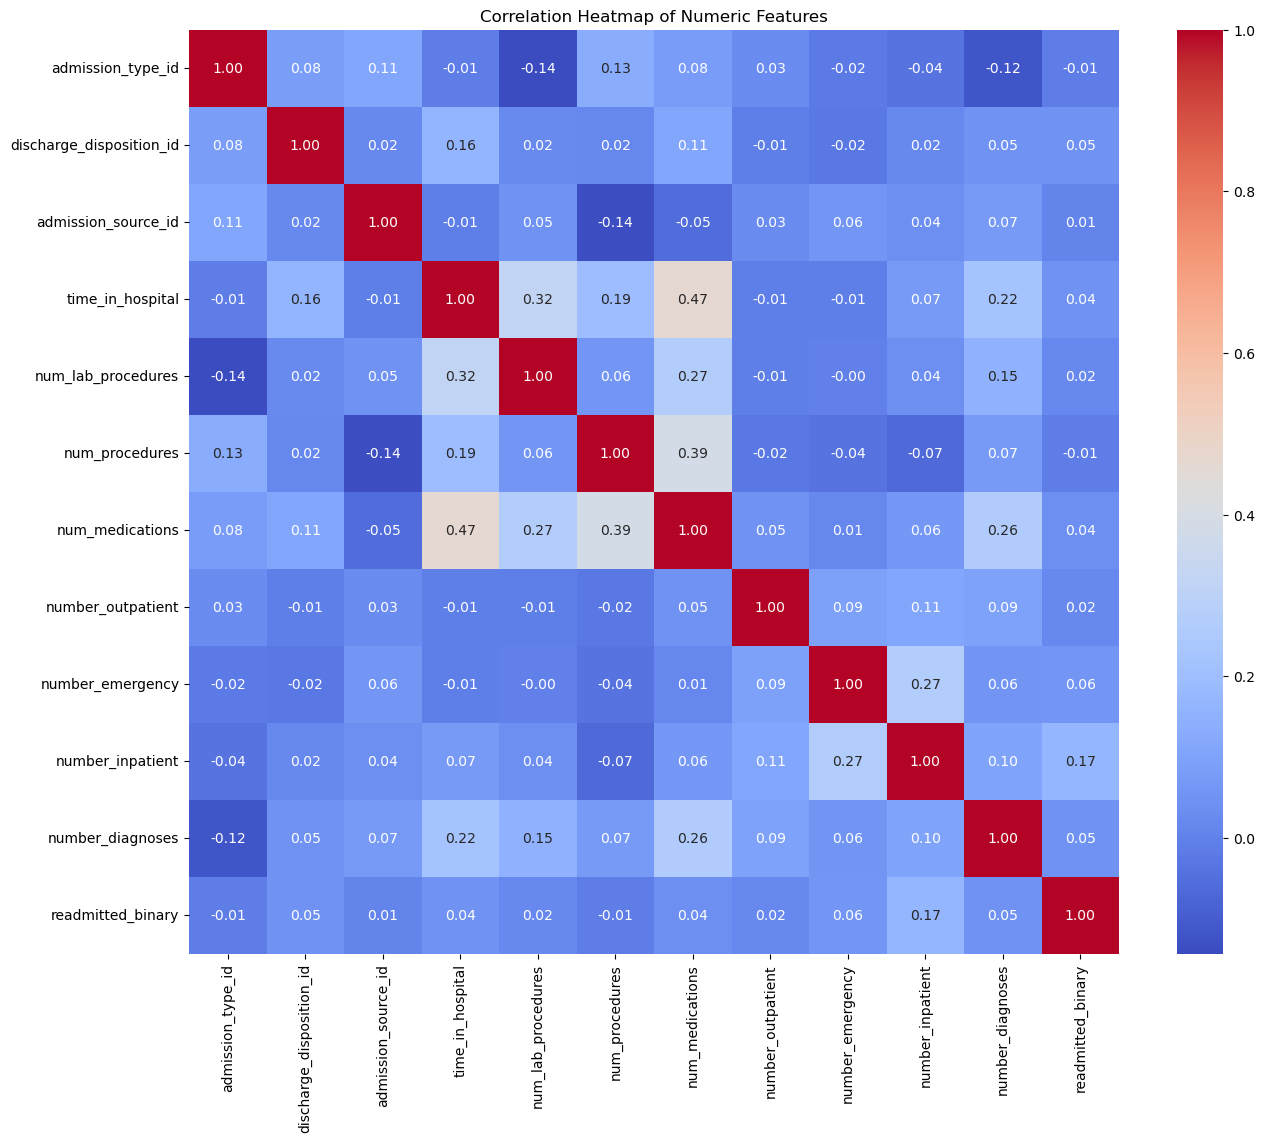

In [29]:
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

cols_to_drop = ['encounter_id', 'patient_nbr']
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.drop(cols_to_drop)

corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(15,12))
sb.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numeric Features")

For this pairplot, I chose a few variables that I thought might affect the readmittance of a patient, such as time in the hospital or number of procedures and medications.

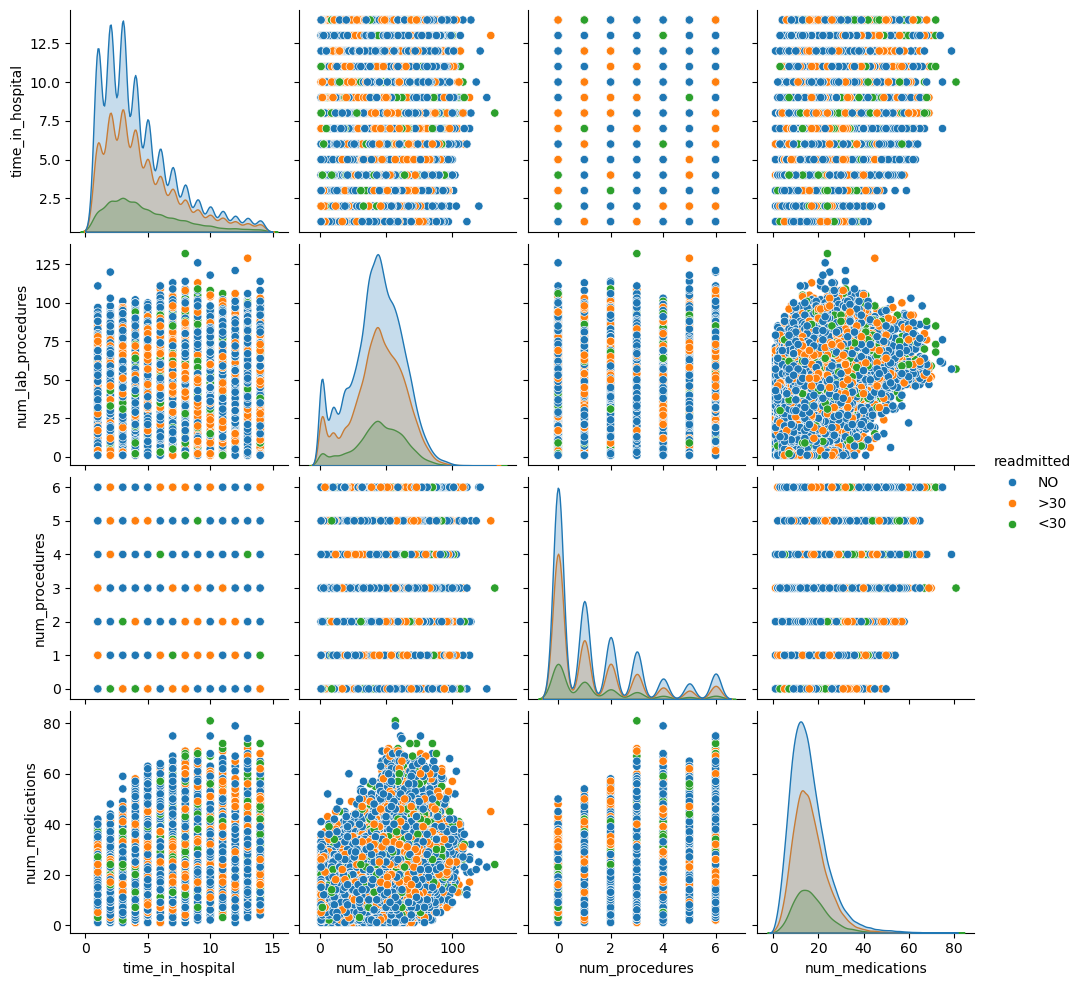

In [31]:
sb.pairplot(data, vars=['time_in_hospital','num_lab_procedures','num_procedures','num_medications'], hue='readmitted')
plt.show()

Here, we can see that a lot of the patients tend to be over the age of 50, as we can see a drastic increase from 30-40 and 50-60 age groups.

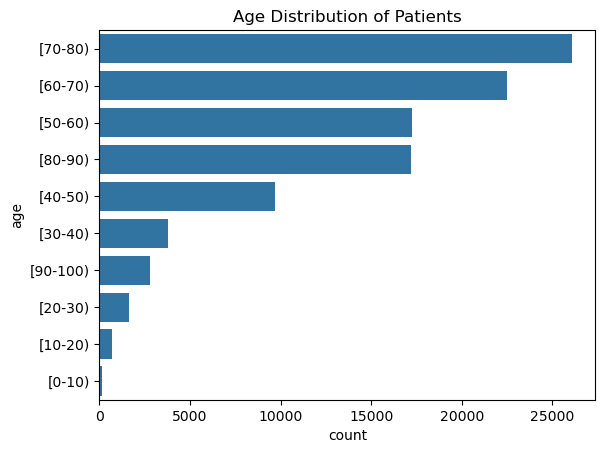

In [33]:
sb.countplot(y='age', data=data, order=data['age'].value_counts().index)
plt.title('Age Distribution of Patients')
plt.show()

The female gender takes is more prominent in this dataset, however the males aren't too far behind, so while they might be a bit unbalance, I don't believe it'll be enough to cause any issues.

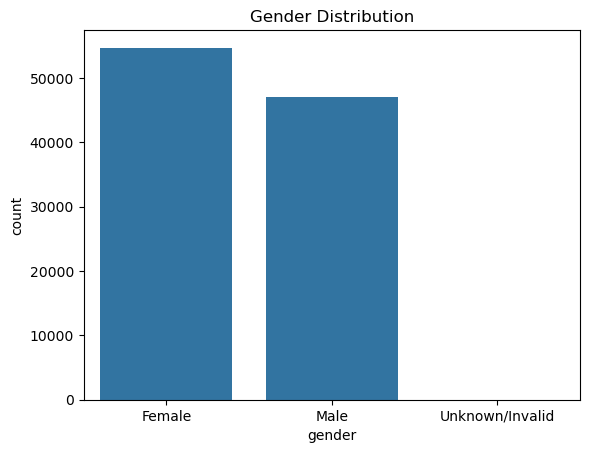

In [35]:
sb.countplot(x='gender', data=data)
plt.title('Gender Distribution')
plt.show()

As we can see here, majority of the dataset is made of caucasians, which means the results of the model will likely be disporpotionately more accurate for caucasian people than for minorities. Given the difference in data, it might not be enough to balance this through weights and such but an attempt will be made regardless.

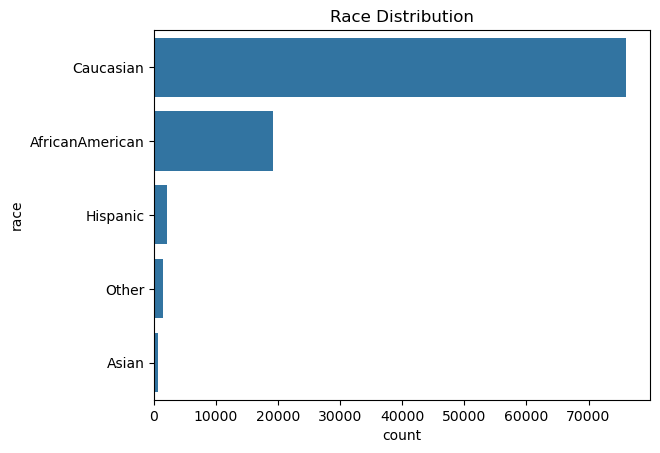

In [37]:
sb.countplot(y='race', data=data, order=data['race'].value_counts().index)
plt.title('Race Distribution')
plt.show()

Here, we see that more than half of the patients were NOT readmitted, and from the ones that were, most of them were readmitted more than 30 days after their first admission.

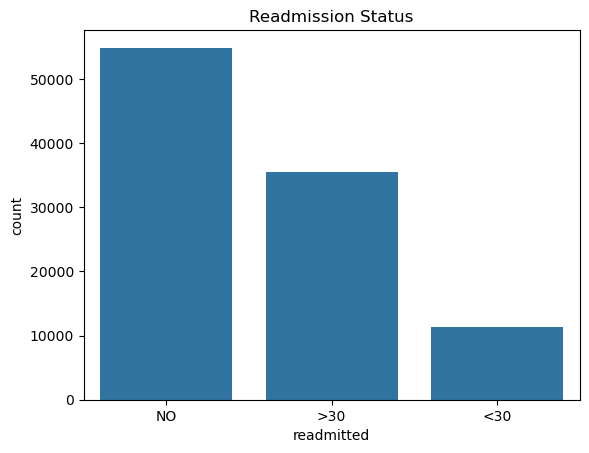

In [39]:
sb.countplot(x='readmitted', data=data)
plt.title('Readmission Status')
plt.show()

Here, we see that the readmission and number of medications boxplots shows no drastic differences between them, meaning the number of medications might not affect much.

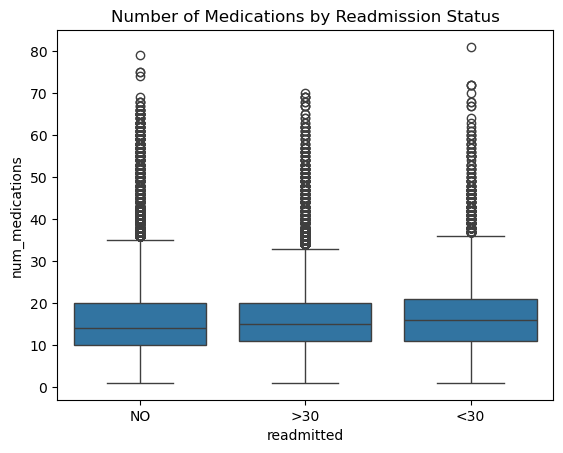

In [41]:
sb.boxplot(x='readmitted', y='num_medications', data=data)
plt.title('Number of Medications by Readmission Status')
plt.show()

Here, we see that most of the admission types for the dataset come from emergency and urgent admissions.

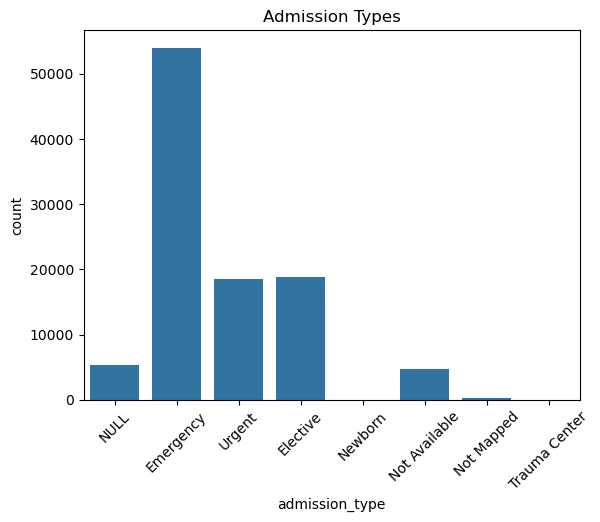

In [43]:
data['admission_type'] = data['admission_type_id'].map({1:'Emergency',2:'Urgent',3:'Elective',4:'Newborn',5:'Not Available',6:'NULL',7:'Trauma Center',8:'Not Mapped'})
sb.countplot(x='admission_type', data=data)
plt.xticks(rotation=45)
plt.title('Admission Types')
plt.show()

Here, we can see the readmission times against the reported insulin prescription. We can see that most people who were not prescribed insulin were not readmitted, meaning they likely didn't need it but the no insulin prescription also has the most people being readmitted within AND after 30 days from all so it's likely these people are not being diagnosed properly. A similar situation may be happening in the steady prescription, as it's the second highest for both readmission, meaning people are likely not getting their dosage adjusted properly, causing them to have to be readmitted in the future.

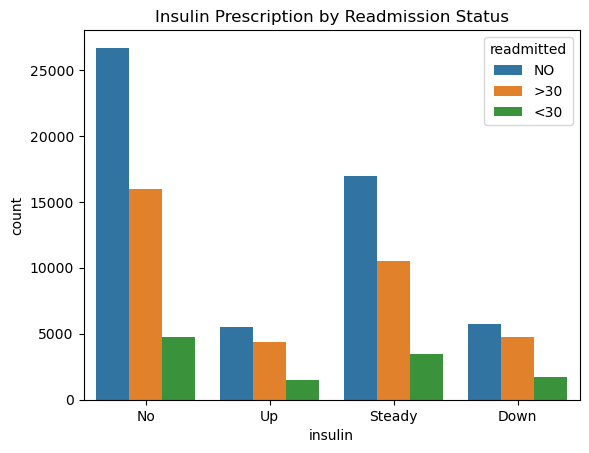

In [45]:
sb.countplot(x='insulin', hue='readmitted', data=data)
plt.title('Insulin Prescription by Readmission Status')
plt.show()

## Modeling

### Data Processing

For preparing the data, I dropped all the columns I previously mentioned were useless, as well as some more useless columns for our model, such as encounter_id and patient_nbr.

In [49]:
data = data.drop(columns={'encounter_id', 'patient_nbr', 'weight', 'max_glu_serum', 'A1Cresult', 'payer_code', 'medical_specialty'})

Since only some of the entries under race are missing, I decided to impute them as Unknown, along with some of the missing entries in the diag columns. I don't believe this will introduce much noise into the model, as there isn't many entries missing from these columns.

In [51]:
data['race'] = data['race'].fillna('Unknown')
data[['diag_1', 'diag_2', 'diag_3']] = data[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown')

Here, I also decided to simplify the readmittion column into a binary column, simply whether a patient was re-admitted or not.

In [53]:
data['readmitted_binary'] = data['readmitted'].apply(lambda x: 1 if (x == '<30' or x == '>30') else 0)

Then, I made dummies for the categorical columns so that I can input them into the model properly.

In [55]:
categorical_cols = data.select_dtypes(include='object').columns
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

After a perfect run of the model I realize that the readmission results were leaking into the training data so I group the readmitted columns and make a redacted copy of the dataset with the readmission data dropped to use as the training data, that way I'm still able to use the readmitted_binary as the item being predicted.

In [57]:
leak_cols = [col for col in data_encoded.columns if col.startswith('readmitted_')]
data_red = data_encoded.drop(columns=leak_cols, errors='ignore')

### Models

Here, I split the data into testing and training, using the previously mentioned redacted data for X and the normal dataset at the Y.

In [60]:
X = data_red
y = data_encoded['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Logistic Regression

This is the first logistic regression model I built. The iterations are at 5000 because it kept not converging.

In [63]:
logreg = LogisticRegression(max_iter=5000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

From the classification report, the ROC-AUC score, and the confusion matrix, we can see that while we have decent overall accuracy (0.63), the model still missed around half of the patients readmitted, which is a problem since this is in a healthcare setting in which these people aren't getting adecuate medical care.

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.75      0.68     16459
           1       0.62      0.49      0.55     14071

    accuracy                           0.63     30530
   macro avg       0.63      0.62      0.62     30530
weighted avg       0.63      0.63      0.62     30530



In [66]:
auc = roc_auc_score(y_test, y_prob)
print('ROC-AUC Score:', auc)

ROC-AUC Score: 0.6688251036815027


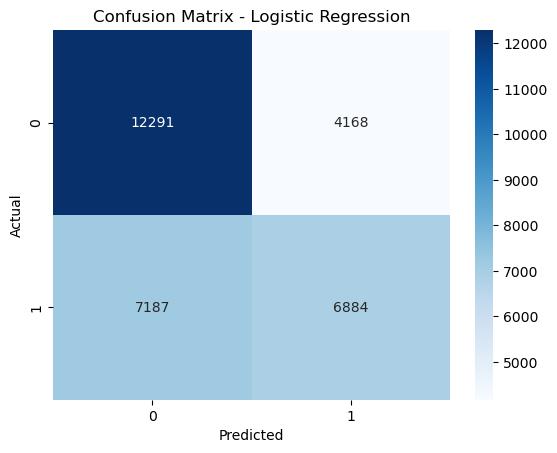

In [67]:
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### Balanced Logistic Regression

Based on the results of the previous model, I decided to adjust the model a bit by balancing the classes a bit, which gave us a pretty decent performance boost. Recall for readmitted patients increased from 0.49 to 0.58, which means the model is now catching more than half of the readmitted patients correctly, while still preserving an overall accuracy of 0.63. This increased recall is ideal for our model's purpose as we're dealing with healthcare, however I do think this could be further improved.

In [70]:
logreg = LogisticRegression(max_iter=5000, class_weight='balanced')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66     16459
           1       0.60      0.58      0.59     14071

    accuracy                           0.63     30530
   macro avg       0.62      0.62      0.62     30530
weighted avg       0.63      0.63      0.63     30530



In [72]:
auc = roc_auc_score(y_test, y_prob)
print('ROC-AUC Score:', auc)

ROC-AUC Score: 0.6689181110358325


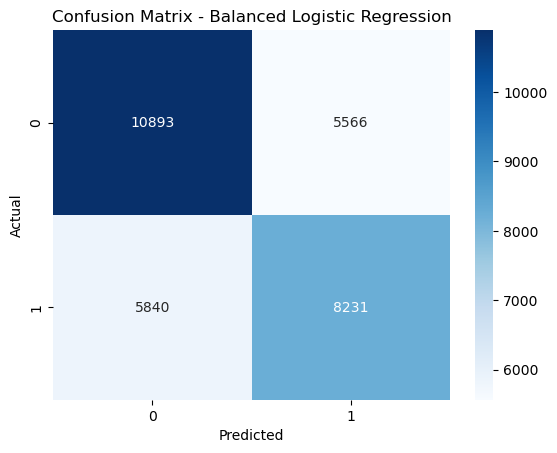

In [73]:
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced Logistic Regression')
plt.show()

#### Balanced and Threshold-Adjusted Logistic Regression

Some progress was made with the previous model, however I felt that it could be tweaked a bit to optimize for better recall while not just flagging everyone as a potential readmittance. I did this by adjust the threshold of the model to around 0.35 to get a better recall while minimizing false positives at the same time.

In [76]:
logreg = LogisticRegression(max_iter=5000, class_weight='balanced')

logreg.fit(X_train, y_train)

y_pred = (logreg.predict_proba(X_test)[:,1] > 0.3).astype(int)
y_prob = logreg.predict_proba(X_test)[:, 1]

Here, we can see the recall for our potential readmittance jumps to around 0.94 at a threshold of 0.3, which mean the model is now catching all potential readmissions, however the precision drops significantly to around 0.49, meaning we're also getting a lot of false positives. However, given the purpose of the model, false positives are techinically fine in this scenario, as it's false negatives that would put people's lives at risk.

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.15      0.25     16459
           1       0.49      0.94      0.64     14071

    accuracy                           0.52     30530
   macro avg       0.62      0.55      0.45     30530
weighted avg       0.63      0.52      0.43     30530



In [79]:
auc = roc_auc_score(y_test, y_prob)
print('ROC-AUC Score:', auc)

ROC-AUC Score: 0.6689181110358325


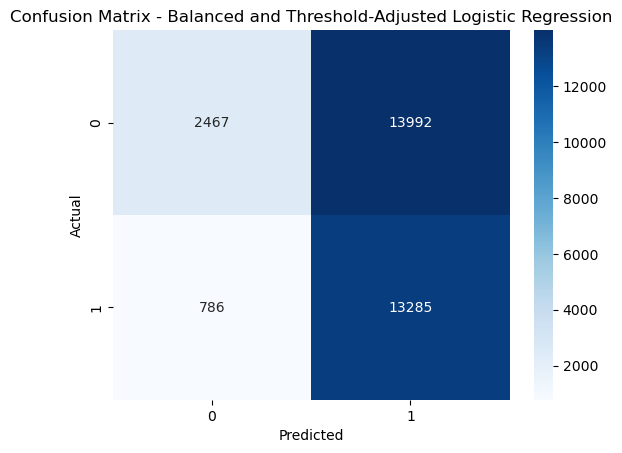

In [80]:
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced and Threshold-Adjusted Logistic Regression')
plt.show()

Using this model, we can see which thresholds give us better performance metrics for the potential readmissions, so here I list the thresholds from 0.1 to 0.9 counting by 0.05. The range from 0.3 to 0.5 has the most promising results as they're the most balanced, they give us high recall while maintaining decent precision and overall accuracy, allowing to identify as many potential readmissions while not overpredicting too much.

In [82]:
y_prob = logreg.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    results.append([thresh, precision, recall, f1])

results = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1-score'])
print(results)

    Threshold  Precision    Recall  F1-score
0        0.10   0.462008  0.999503  0.631919
1        0.15   0.463802  0.997086  0.633108
2        0.20   0.467633  0.990335  0.635286
3        0.25   0.474355  0.974060  0.638008
4        0.30   0.487040  0.944140  0.642595
5        0.35   0.504094  0.888139  0.643148
6        0.40   0.529382  0.805415  0.638857
7        0.45   0.562354  0.701514  0.624273
8        0.50   0.596579  0.584962  0.590713
9        0.55   0.630708  0.463293  0.534191
10       0.60   0.669909  0.357260  0.466002
11       0.65   0.692996  0.258759  0.376818
12       0.70   0.724972  0.181153  0.289873
13       0.75   0.761271  0.126004  0.216220
14       0.80   0.791753  0.081871  0.148396
15       0.85   0.821510  0.051027  0.096086


Here, we see that a threshold of 0.35 in a balanced logistic regression gives us a recall of 0.89, meaning the model can identify the majority of patients who might be readmitted. However, this comes at the cost that the model also predicts more false positives, as seen in the precision of 0.50 and the overall accuracy of 0.55.

In [84]:
y_pred_custom = (y_prob > 0.35).astype(int)

print(classification_report(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.73      0.25      0.38     16459
           1       0.50      0.89      0.64     14071

    accuracy                           0.55     30530
   macro avg       0.61      0.57      0.51     30530
weighted avg       0.62      0.55      0.50     30530



As for the ROC-AUC score, while it's relatively low at a 0.669, I believe this score is quite decent given the simplicity of the model and the fact that this is achieved using real medical data which is often messy and complex, making it hard to achieve high ROC-AUC scores without more complex models and datasets.

In [86]:
auc = roc_auc_score(y_test, y_prob)
print('ROC-AUC Score:', auc)

ROC-AUC Score: 0.6689181110358325


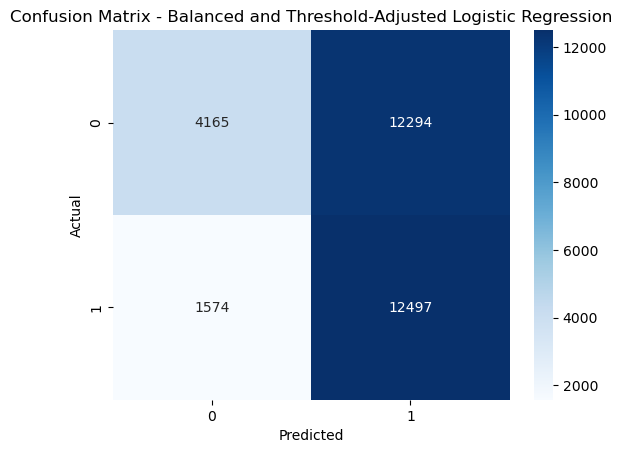

In [87]:
cm = confusion_matrix(y_test, y_pred_custom)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Balanced and Threshold-Adjusted Logistic Regression')
plt.show()